## Business Problem
### Description
*** Ref: https://www.kaggle.com/c/quora-question-pairs/***

* Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.<br/> <br/>

* Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

### Problem Statement
* Identify which questions asked on Quora are duplicates of questions that have already been asked. This could be useful to instantly provide answers to questions that have already been answered. <br/>
** We are tasked with predicting whether a pair of questions are duplicates or not.**

### Identifying Business Constraints Problem Formulation
1. The cost of a mis-classification can be very high. i.e False Positives should be highly penalised, we do not want to link dissimilar questions together as the trust of user will reduce because of this.
2. We would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.
5. It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

### Data overview
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290

### Performance Metric (decided by kaggle)
Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
1. log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
2. Binary Confusion Matrix

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import os
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display,Markdown
# os.chdir('E:/Projects/QuoraQuestionPairSimilarity')

In [2]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Observations:
We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

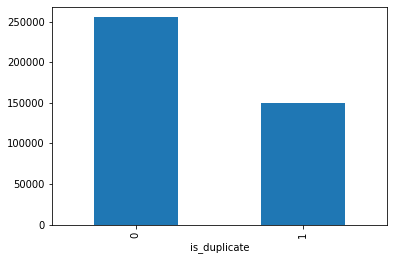

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [6]:
display(Markdown('''### Observations: 
* Total number of question pairs for training:\n   {}
* Question pairs are not Similar (is_duplicate = 0):\n   {}%
* Question pairs are Similar (is_duplicate = 1):\n   {}%'''.format(len(df),100 - round(df['is_duplicate'].mean()*100, 2),round(df['is_duplicate'].mean()*100, 2))))

### Observations: 
* Total number of question pairs for training:
   404290
* Question pairs are not Similar (is_duplicate = 0):
   63.08%
* Question pairs are Similar (is_duplicate = 1):
   36.92%

### Number of unique questions

In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

q_vals=qids.value_counts()

q_vals=q_vals.values

In [8]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

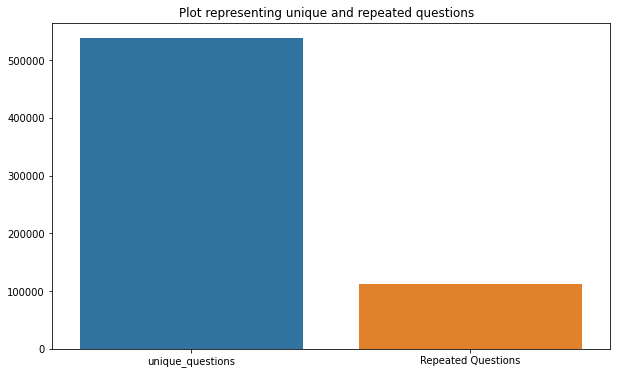

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### Number of occurrences of each question

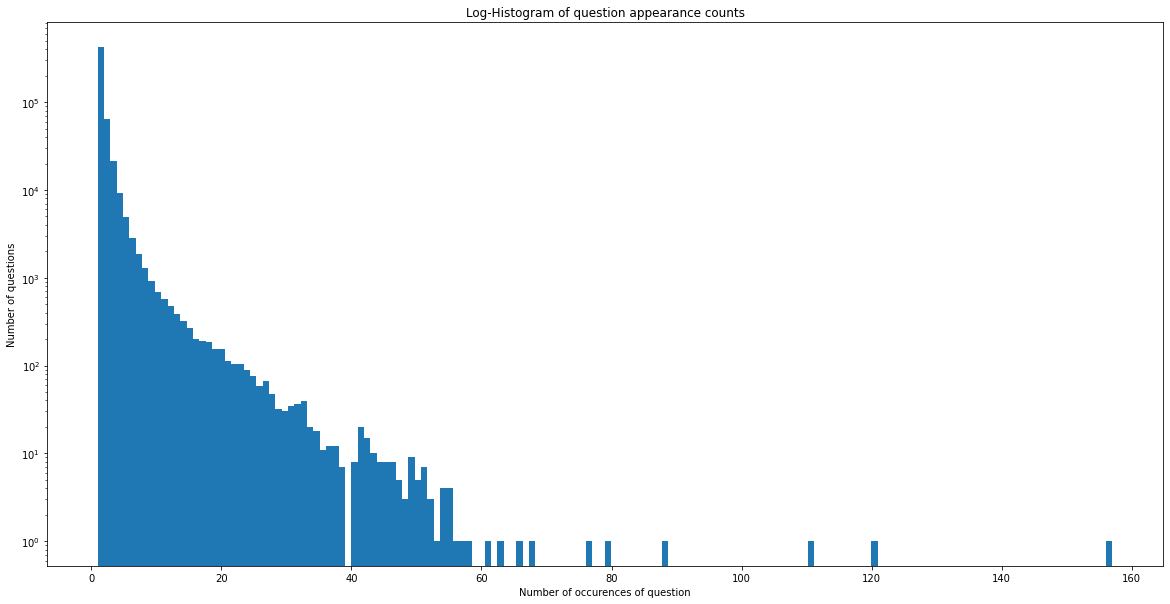

In [10]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
plt.show()

### Checking for NULL values

In [11]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [12]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [13]:
display(Markdown('''### Observations:
* Total number of  Unique Questions are: {0}
* Number of unique questions that appear more than one time: {1} ({2}%)
* Max number of times a single question is repeated: {3}
* Number of duplicate questions {4}
* There are two rows with null values in question2 and one null value in question1 '''.format(unique_qs,qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,3),max(qids.value_counts()),(pair_duplicates).shape[0] - df.shape[0])))

### Observations:
* Total number of  Unique Questions are: 537933
* Number of unique questions that appear more than one time: 111780 (20.78%)
* Max number of times a single question is repeated: 157
* Number of duplicate questions 0
* There are two rows with null values in question2 and one null value in question1 

### Note: I came up with following features after a lot of reading of kaggle discussions and after lots of hit and trail.

### Basic Feature Extraction (before cleaning)

I used following features:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
# Ref: https://towardsdatascience.com/apply-function-to-pandas-dataframe-rows-76df74165ee4
# Ref: https://stackoverflow.com/questions/33518124/how-to-apply-a-function-on-every-row-on-a-dataframe
if os.path.isfile('df_fe_without_preprocessing_train.pkl'):
    df = pd.read_pickle("df_fe_without_preprocessing_train.pkl")
elif isinstance(df,pd.core.frame.DataFrame):
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_pickle("df_fe_without_preprocessing_train.pkl")
else:
    print("Unexpected input encountered")

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [40]:
df[["freq_qid1","freq_qid2","q1len","q2len","q1_n_words","q2_n_words","word_Common","word_Total","word_share","freq_q1+q2","freq_q1-q2"]].describe()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,2.827609,3.046961,59.536709,60.108365,10.944592,11.185120,4.511610,21.126112,0.223362,5.874570,1.845715
std,4.487418,6.026871,29.940655,33.863870,5.431949,6.311076,3.098656,8.592622,0.128336,9.091068,5.187882
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000
25%,1.000000,1.000000,39.000000,39.000000,7.000000,7.000000,2.000000,15.000000,0.125000,2.000000,0.000000
50%,1.000000,1.000000,52.000000,51.000000,10.000000,10.000000,4.000000,19.000000,0.217391,3.000000,0.000000
75%,3.000000,2.000000,72.000000,72.000000,13.000000,13.000000,6.000000,25.000000,0.318182,5.000000,2.000000
max,50.000000,120.000000,623.000000,1169.000000,125.000000,237.000000,41.000000,166.000000,0.500000,157.000000,119.000000


### Analysis of some of the extracted features

In [46]:
display(Markdown('''### Observations:
1. Here some questions have only one single word and some also have one letter.
2. Minimum  and Maximum no.of words of the questions in question1 respectively are {} and {}
3. Minimum and Maximum no.of words of the questions in question2 respectively are {} and {}
4. Number of Questions with minimum length [question1] : {}
5. Number of Questions with minimum length [question2] : {}
6. The Above Values show high variance in the dataset.
7. I may be adding multicollinearity to the data which I've dealt before finalizing my train data.'''.format(min(df['q1_n_words']),max(df['q1_n_words']),min(df['q2_n_words']),max(df['q2_n_words']),df[df['q1_n_words']== 1].shape[0],df[df['q2_n_words']== 1].shape[0])))

### Observations:
1. Here some questions have only one single word and some also have one letter.
2. Minimum  and Maximum no.of words of the questions in question1 respectively are 1 and 125
3. Minimum and Maximum no.of words of the questions in question2 respectively are 1 and 237
4. Number of Questions with minimum length [question1] : 67
5. Number of Questions with minimum length [question2] : 24
6. The Above Values show high variance in the dataset.
7. I may be adding multicollinearity to the data which I've dealt before finalizing my train data.

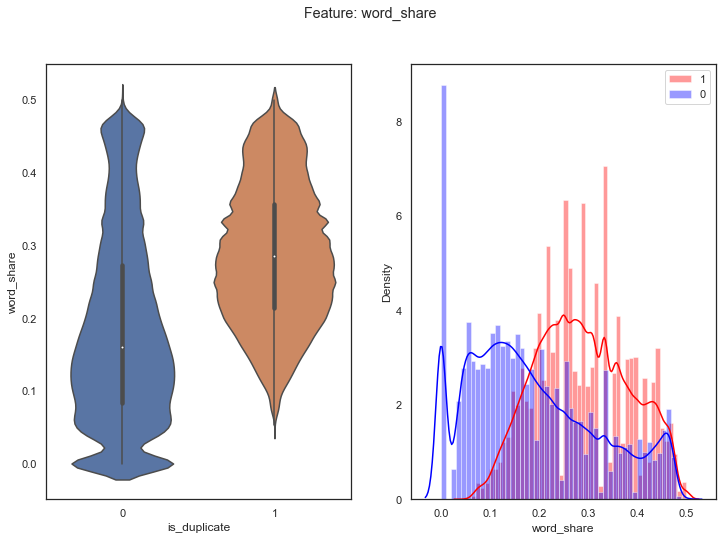

In [66]:
f= plt.figure(figsize=(12, 8))
f.suptitle('Feature: word_share')
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

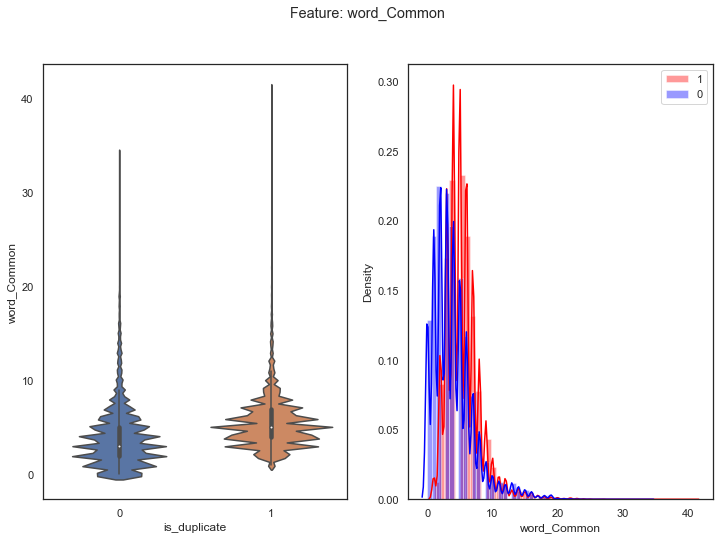

In [67]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Feature: word_Common')
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

### Observations
- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.
- The distributions for normalized word_share w.r.t hue=
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)
- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.Thus, this feature may give less feature importance.